# 📊 Exploratory Data Analysis (EDA)
## Hull Tactical Market Prediction - Phase 1

**Date:** 2025-11-11

**Objectives:**
1. Feature Group Analysis (M/E/I/P/V/S/D)
2. Target Variable Time Series Characteristics  
3. Correlation Analysis
4. Market Regime Identification
5. Train/Test Distribution Shift Detection
6. Feature Stationarity Assessment
7. Benchmark Calculation

## 1. Setup and Imports

In [1]:
# Standard libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Get project root (go up one level from notebooks folder)
notebook_dir = os.getcwd() if '__file__' not in dir() else os.path.dirname(os.path.abspath(__file__))
project_root = os.path.dirname(notebook_dir) if 'notebooks' in notebook_dir else notebook_dir
sys.path.insert(0, project_root)

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Clustering
from sklearn.cluster import KMeans

# Project utilities
from src.data import DataLoader, calculate_benchmark_score
from src.utils import set_seed, load_config

# Load configuration (using absolute path from project root)
config_path = os.path.join(project_root, 'conf', 'params.yaml')
config = load_config(config_path)
print(f"📋 Loaded config from: {config_path}")
print(f"📋 Seed: {config['seed']}")

# Set random seed from config
set_seed(config['seed'])

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings  
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('✅ Setup complete!')

📋 Loaded config from: /Users/gimjunseog/projects/hull_prediction_market/conf/params.yaml
📋 Seed: 42
✅ Setup complete!


## 2. Load Data

In [2]:
# Change working directory to project root
os.chdir(project_root)
print(f"📂 Working directory: {os.getcwd()}")

# Initialize DataLoader (now it can find conf/params.yaml)
loader = DataLoader()

# Load data
train_df, test_df = loader.load_data()

print(f'📦 Train: {train_df.shape}, Test: {test_df.shape}')
print(f'📅 Date range: {train_df["date_id"].min()} - {train_df["date_id"].max()}')

# Display feature groups
print('\n🏷️ Feature Groups:')
for group, features in loader.feature_groups.items():
    print(f'  {group}: {len(features)} features')

train_df.head()

2025-11-21 15:34:08,916 - shared_logger - INFO - Data directory found: data/raw
2025-11-21 15:34:08,917 - shared_logger - INFO - Starting: Loading data
2025-11-21 15:34:08,917 - shared_logger - INFO - Loading train data from data/raw/train.csv
2025-11-21 15:34:09,006 - shared_logger - INFO - Loading test data from data/raw/test.csv
2025-11-21 15:34:09,009 - shared_logger - INFO - Feature groups identified:
2025-11-21 15:34:09,009 - shared_logger - INFO -   M: 18 features
2025-11-21 15:34:09,010 - shared_logger - INFO -   E: 20 features
2025-11-21 15:34:09,010 - shared_logger - INFO -   I: 9 features
2025-11-21 15:34:09,010 - shared_logger - INFO -   P: 13 features
2025-11-21 15:34:09,011 - shared_logger - INFO -   V: 13 features
2025-11-21 15:34:09,011 - shared_logger - INFO -   S: 12 features
2025-11-21 15:34:09,011 - shared_logger - INFO -   D: 9 features
2025-11-21 15:34:09,017 - shared_logger - INFO - Data loaded and sorted by date_id
2025-11-21 15:34:09,020 - shared_logger - INFO 

📂 Working directory: /Users/gimjunseog/projects/hull_prediction_market
📦 Train: (9021, 98), Test: (10, 99)
📅 Date range: 0 - 9020

🏷️ Feature Groups:
  M: 18 features
  E: 20 features
  I: 9 features
  P: 13 features
  V: 13 features
  S: 12 features
  D: 9 features


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0024,0.0003,-0.0030
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0085,0.0003,-0.0091
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0096,0.0003,-0.0102
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0047,0.0003,0.0040
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0117,0.0003,-0.0123


## 3. Data Quality Check

2025-11-21 15:34:09,060 - shared_logger - INFO - Data directory found: data/raw
2025-11-21 15:34:09,060 - shared_logger - INFO - Starting: Loading data
2025-11-21 15:34:09,061 - shared_logger - INFO - Loading train data from data/raw/train.csv


MISSING VALUE ANALYSIS


2025-11-21 15:34:09,126 - shared_logger - INFO - Loading test data from data/raw/test.csv
2025-11-21 15:34:09,128 - shared_logger - INFO - Feature groups identified:
2025-11-21 15:34:09,128 - shared_logger - INFO -   M: 18 features
2025-11-21 15:34:09,129 - shared_logger - INFO -   E: 20 features
2025-11-21 15:34:09,129 - shared_logger - INFO -   I: 9 features
2025-11-21 15:34:09,129 - shared_logger - INFO -   P: 13 features
2025-11-21 15:34:09,130 - shared_logger - INFO -   V: 13 features
2025-11-21 15:34:09,130 - shared_logger - INFO -   S: 12 features
2025-11-21 15:34:09,130 - shared_logger - INFO -   D: 9 features
2025-11-21 15:34:09,133 - shared_logger - INFO - Data loaded and sorted by date_id
2025-11-21 15:34:09,134 - shared_logger - INFO - Completed: Loading data - Time: 0.07s



1. Missing Summary (first 20 features):
   feature group  missing_count  missing_pct  first_valid_idx  last_valid_idx
7       E7     E           6969      77.2531             6969            9020
8      V10     V           6049      67.0547             6049            9020
11      S3     S           5733      63.5517             5733            9020
0       M1     M           5547      61.4899             5547            9020
1      M13     M           5540      61.4123             5540            9020
2      M14     M           5540      61.4123             5540            9020
6       M6     M           5043      55.9029             5043            9020
9       V9     V           4539      50.3159             4539            9020
10     S12     S           3537      39.2085             3537            9020
5       M5     M           3283      36.3929             3283            9020
3       M2     M           3217      35.6612             3217            9020
12      S8     S       

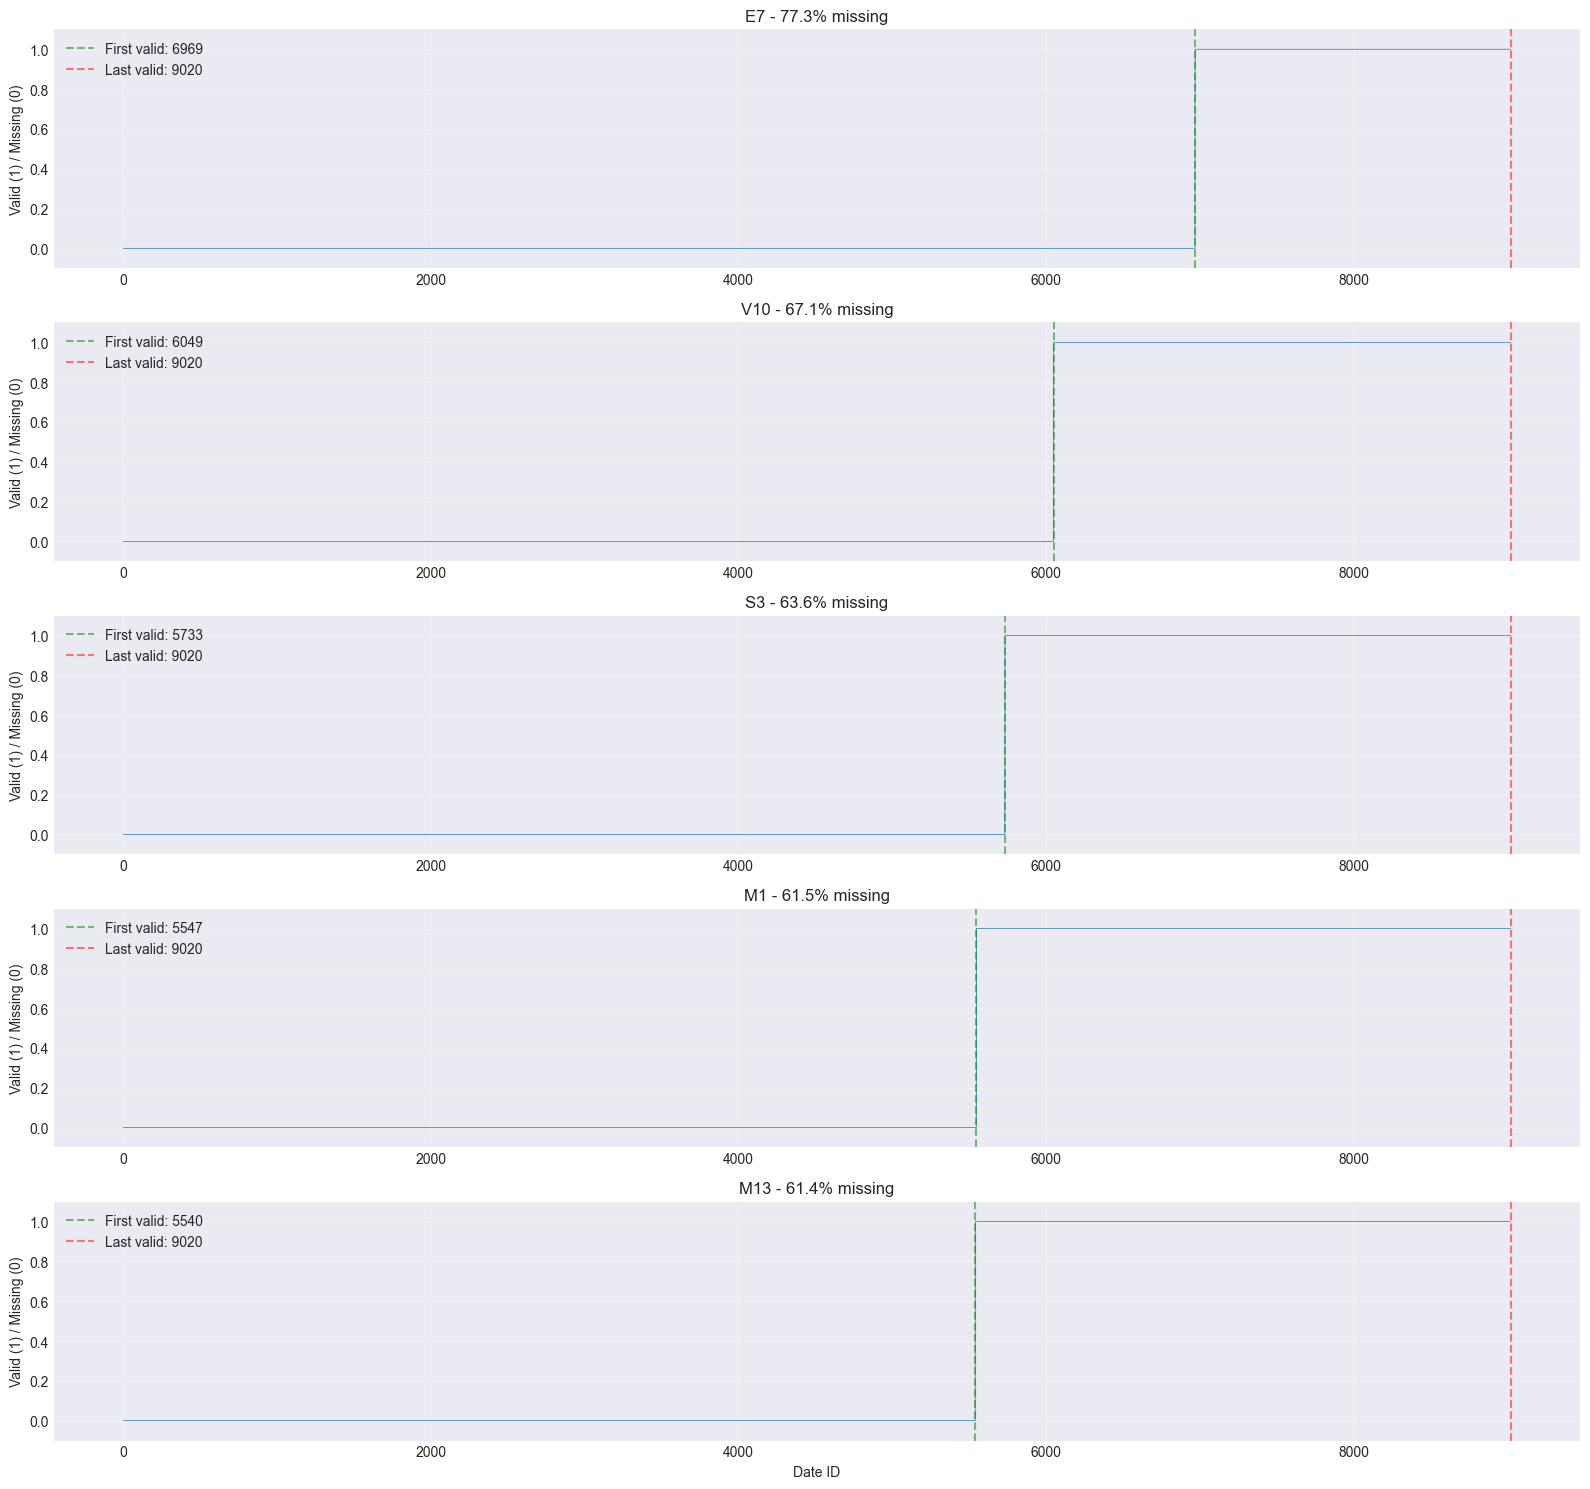


✅ Missing value analysis complete!


In [3]:
# Missing value comprehensive analysis
print("="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)
loader = DataLoader()
train_df, _ = loader.load_data()
# 1. Get missing summary from DataLoader
missing_summary = loader.get_missing_summary(train_df)
print("\n1. Missing Summary (first 20 features):")
print(missing_summary.head(20))

# 2. Check for intermittent missing values
print("\n2. Intermittent Missing Detection:")
print("-" * 60)

features_with_intermittent = []
features_initial_only = []

for col in train_df.columns:
    if col in ['date_id', 'is_scored', 'forward_returns']:
        continue
    
    series = train_df[col]
    
    # Find first valid index : 시리즈에서 첫 번째로 '유효한 값(= NaN이 아닌 값)'이 등장하는 index(행 번호)를 찾는 함수
    first_valid = series.first_valid_index()
    
    if first_valid is None:
        continue  # Completely missing column
    
    # Check if there are any NaN values AFTER first valid index
    after_first_valid = series.loc[first_valid:]
    has_intermittent = after_first_valid.isna().any() # 결측치가 존재하면 True, 없으면 False
    
    if has_intermittent:
        features_with_intermittent.append(col)
    else:
        features_initial_only.append(col)

print(f"Features with intermittent missing: {len(features_with_intermittent)}")
print(f"Features with initial-only missing: {len(features_initial_only)}")

if features_with_intermittent:
    print(f"\n⚠️ Features with intermittent gaps (first 10):")
    for feat in features_with_intermittent[:10]:
        print(f"  - {feat}")
else:
    print("\n✅ No intermittent missing values found - all missing is initial only!")

# 3. Visualize missing patterns for top features
print("\n3. Missing Pattern Visualization (top 5 features by missing %):")
print("-" * 60)

top_missing = missing_summary.nlargest(5, 'missing_pct') # nlargest : missing_pct 칼럼에서 값이 가장 큰 n개의 행을 내림차순으로 반환.

fig, axes = plt.subplots(len(top_missing), 1, figsize=(16, 3*len(top_missing)))
if len(top_missing) == 1:
    axes = [axes]

for idx, (_, row) in enumerate(top_missing.iterrows()):
    feat = row['feature']
    series = train_df[feat]
    
    # Create binary mask (1=valid, 0=missing)
    # ~series.isna() : 값 존재 여부, astype(int) : bool 값을 int형으로 변환
    mask = (~series.isna()).astype(int)
    
    axes[idx].plot(train_df['date_id'], mask, linewidth=0.5)
    axes[idx].set_title(f"{feat} - {row['missing_pct']:.1f}% missing")
    axes[idx].set_ylabel('Valid (1) / Missing (0)')
    axes[idx].set_ylim(-0.1, 1.1)
    axes[idx].grid(True, alpha=0.3)
    
    # Mark first and last valid indices
    if row['first_valid_idx'] >= 0:
        first_date = train_df.loc[row['first_valid_idx'], 'date_id']
        axes[idx].axvline(x=first_date, color='green', linestyle='--', 
                         alpha=0.5, label=f'First valid: {first_date}')
    if row['last_valid_idx'] >= 0:
        last_date = train_df.loc[row['last_valid_idx'], 'date_id']
        axes[idx].axvline(x=last_date, color='red', linestyle='--', 
                         alpha=0.5, label=f'Last valid: {last_date}')
    axes[idx].legend(loc='upper left')

axes[-1].set_xlabel('Date ID')
plt.tight_layout()
plt.show()

# 결측치 많은 칼럼 5개 시각화.
print("\n✅ Missing value analysis complete!")

## 4. Feature Group Analysis


M Features (18)
             M1       M10       M11       M12       M13       M14       M15  \
count 3474.0000 8015.0000 8015.0000 8015.0000 3481.0000 3481.0000 8015.0000   
mean    -0.6210    0.0583   -0.2887    0.4786   -0.9516   -0.8636    0.4614   
std      0.9969    1.3160    1.2215    1.3949    0.6512    0.1923    0.2738   
min     -2.5229   -4.7658   -3.1902   -2.9934   -1.9321   -1.3259    0.0007   
25%     -1.3345   -0.8651   -1.1205   -0.4689   -1.3946   -0.9767    0.2060   
50%     -0.8050    0.1298   -0.2904    0.4889   -1.0890   -0.7965    0.4934   
75%     -0.0447    1.0867    0.3927    1.4716   -0.5821   -0.7048    0.6895   
max      5.1259    3.4012    7.7607    5.2021    1.0263   -0.5862    1.0000   

            M16       M17       M18        M2        M3        M4        M5  \
count 8015.0000 8015.0000 8015.0000 5804.0000 7003.0000 8015.0000 5738.0000   
mean     0.2319    0.2725    0.5992    0.0859    0.1492   -0.0023    0.2365   
std      0.3266    0.2265    0.344

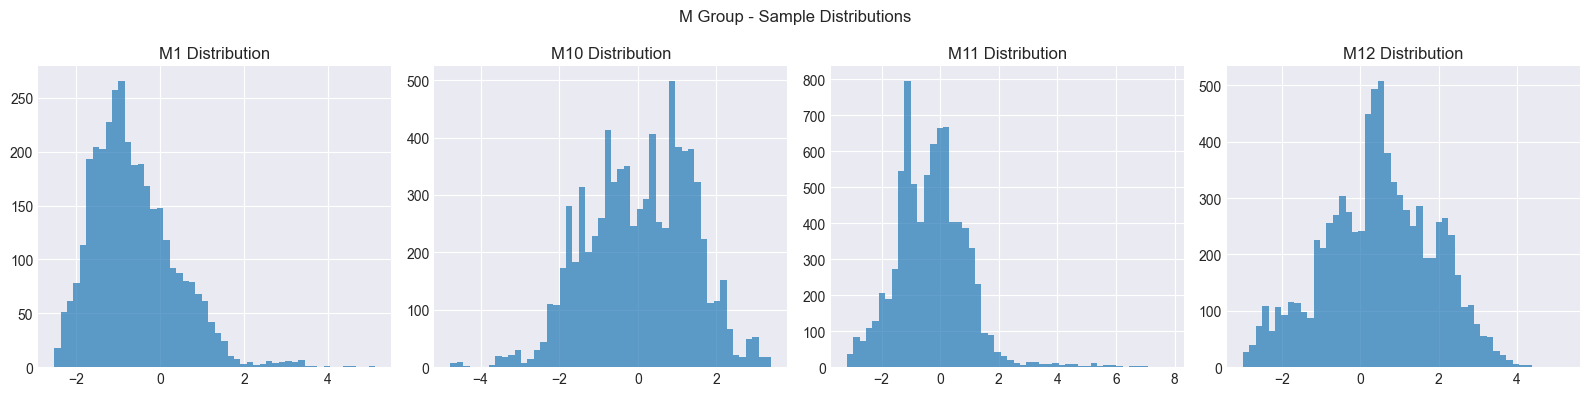


E Features (20)
             E1       E10       E11       E12       E13       E14       E15  \
count 7237.0000 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000   
mean     1.5644    0.5037    0.1254    0.1183    0.0123    0.0070    0.4868   
std      0.6325    0.3369    0.2454    0.2516    0.0192    0.0121    0.3491   
min      0.3251    0.0007    0.0007    0.0007    0.0007    0.0007    0.0007   
25%      1.1158    0.1663    0.0050    0.0036    0.0030    0.0023    0.1286   
50%      1.5167    0.5046    0.0195    0.0069    0.0053    0.0043    0.4421   
75%      1.8748    0.8221    0.0870    0.0741    0.0152    0.0063    0.8391   
max      4.8439    1.0000    1.0000    1.0000    0.1700    0.1184    1.0000   

            E16       E17       E18       E19        E2       E20        E3  \
count 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000 7405.0000 8015.0000   
mean    -0.0480   -0.0093    0.0980    0.1168    0.5040    0.9054    0.3462   
std      1.1357    1.1576    1.144

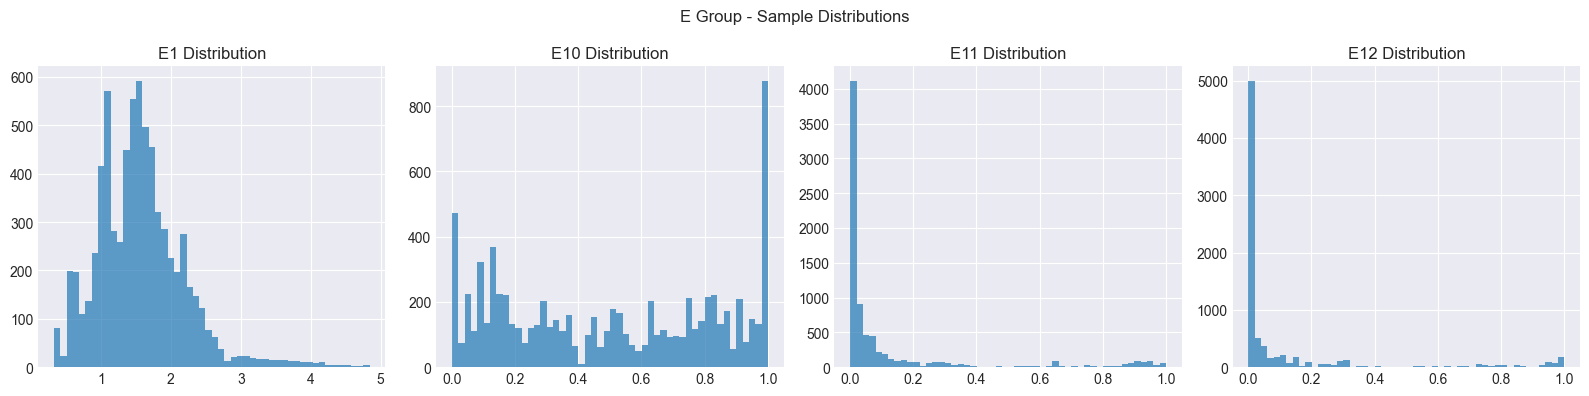


I Features (9)
             I1        I2        I3        I4        I5        I6        I7  \
count 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000   
mean     0.7453   -0.5229    0.6075    0.5511    0.1863    0.4564    0.7068   
std      0.2454    1.2521    0.3320    0.3067    1.6393    0.3024    0.2574   
min      0.0026   -3.5423    0.0007    0.0007   -4.4492    0.0007    0.0033   
25%      0.5569   -1.4676    0.3084    0.3148   -1.0252    0.1653    0.5265   
50%      0.8317   -0.7530    0.6901    0.5255   -0.0898    0.4610    0.7599   
75%      0.9590    0.1888    0.9243    0.8287    1.2914    0.7044    0.9398   
max      1.0000    6.3767    1.0000    1.0000    4.8899    1.0000    1.0000   

             I8        I9  
count 8015.0000 8015.0000  
mean     0.5728    0.1878  
std      0.3257    1.6388  
min      0.0007   -4.5466  
25%      0.3052   -1.0236  
50%      0.5972   -0.0920  
75%      0.8935    1.2930  
max      1.0000    4.9205  


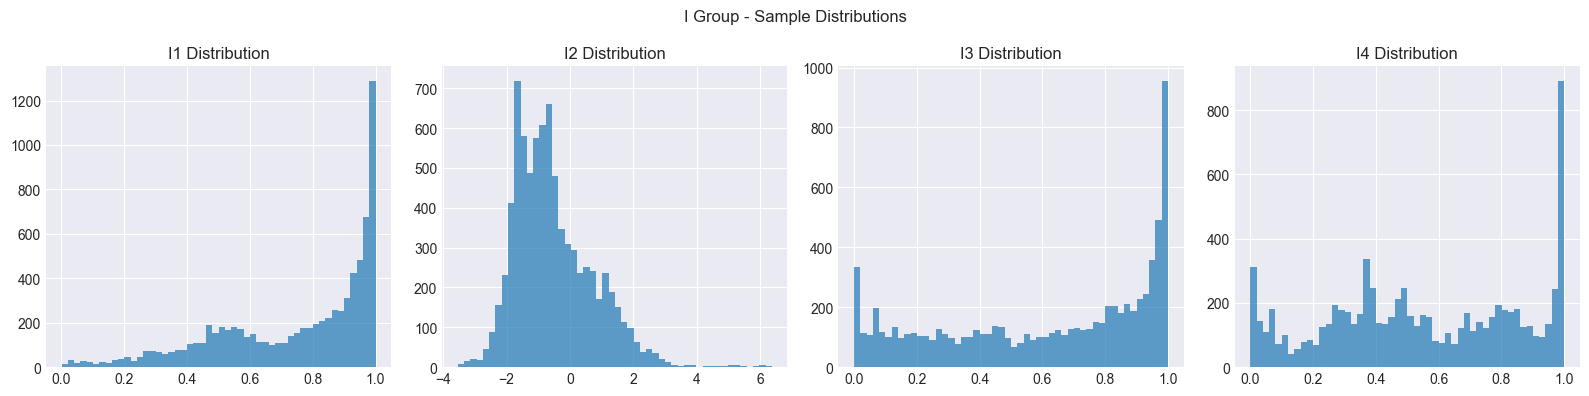


P Features (13)
             P1       P10       P11       P12       P13        P2        P3  \
count 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000 8015.0000   
mean     0.5277    1.4688    1.2603   -0.0205    0.5087   -0.3650    0.4954   
std      0.3274    0.8137    1.0954    1.0851    0.2837    1.4444    0.2884   
min      0.0007   -1.1628   -2.7190   -1.5393    0.0023   -3.1409    0.0440   
25%      0.2262    1.0896    0.6437   -0.7150    0.2652   -1.4179    0.2442   
50%      0.5390    1.7288    1.5497   -0.3804    0.5384   -0.5207    0.4947   
75%      0.8413    2.0538    2.0800    0.2881    0.7419    0.5438    0.7434   
max      1.0000    2.6442    3.0562    9.9756    1.0000    7.2110    0.9785   

             P4        P5        P6        P7        P8        P9  
count 8015.0000 7447.0000 7383.0000 7405.0000 8015.0000 8015.0000  
mean     0.5004    0.0012    0.0529    0.2492    1.5431    0.3937  
std      0.2882    1.0690    1.1504    1.1321    0.7076    0.3854  

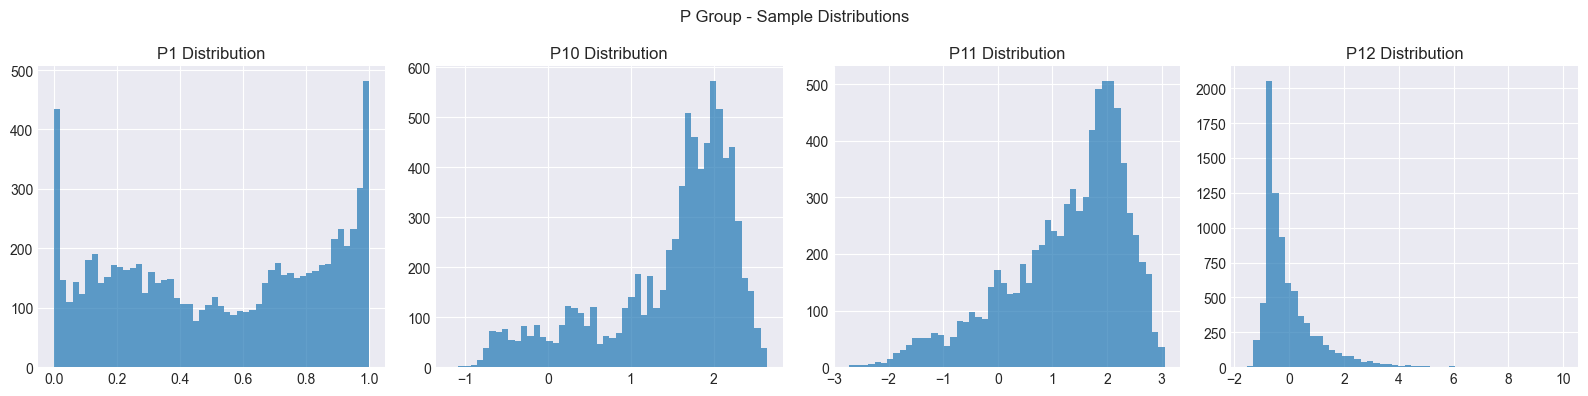


V Features (13)
             V1       V10       V11       V12       V13        V2        V3  \
count 8015.0000 2972.0000 8015.0000 8015.0000 7510.0000 8015.0000 8015.0000   
mean     0.3258   -0.0036    0.2306    0.2540    0.1113    0.5090    0.4891   
std      0.3458    1.2413    0.3157    0.3063    1.3285    0.3059    0.3061   
min      0.0007   -1.4735    0.0007    0.0007   -4.7703    0.0007    0.0007   
25%      0.0007   -0.8169    0.0007    0.0007   -0.6874    0.2427    0.2067   
50%      0.1978   -0.3897    0.0007    0.0999   -0.2248    0.5132    0.4914   
75%      0.6379    0.5481    0.4610    0.4755    0.4736    0.7765    0.7599   
max      1.0000   12.7422    1.0000    1.0000   24.1515    1.0000    1.0000   

             V4        V5        V6        V7        V8        V9  
count 8015.0000 7509.0000 8015.0000 7510.0000 8015.0000 4482.0000  
mean     0.5066    0.3736    0.2889    0.1459    0.3032    0.1252  
std      0.3062    1.1511    0.3129    1.3248    0.3506    1.2739  

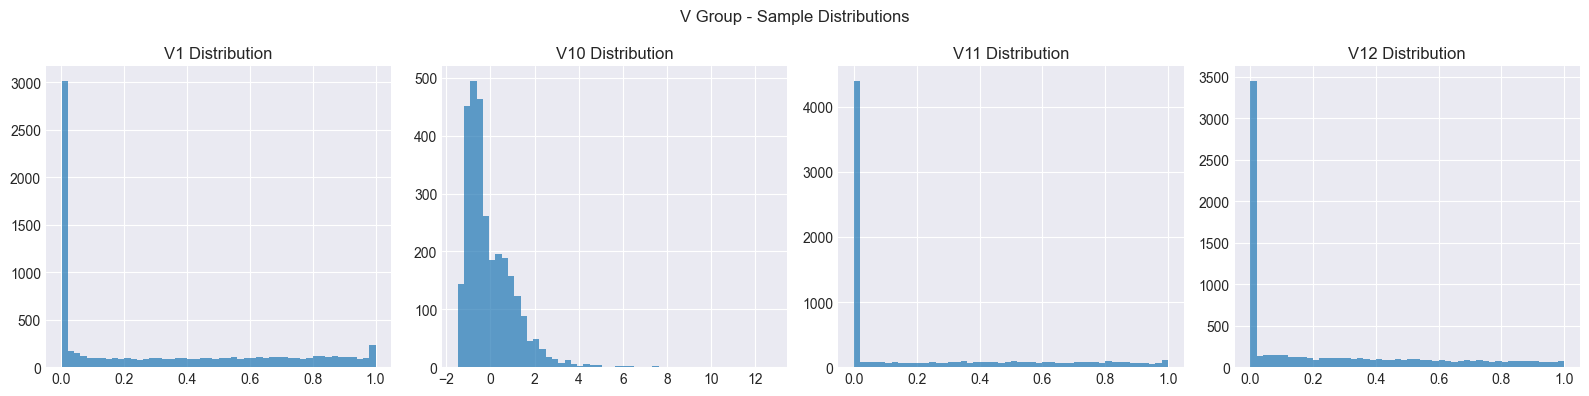


S Features (12)
             S1       S10       S11       S12        S2        S3        S4  \
count 8015.0000 8015.0000 8015.0000 5484.0000 8015.0000 3288.0000 8015.0000   
mean     0.2410    0.4380    0.4329    0.2654    0.0251    0.0603    0.4560   
std      1.4203    0.3224    0.3246    0.9564    1.0228    1.0068    0.3263   
min     -1.9354    0.0007    0.0007   -2.1035   -3.4298   -3.4722    0.0007   
25%     -0.8341    0.1343    0.1184   -0.4311   -0.6570   -0.7126    0.1442   
50%     -0.1286    0.4279    0.4180    0.2078    0.1318    0.1707    0.4616   
75%      0.9813    0.7209    0.7196    0.8517    0.7815    0.8590    0.7464   
max      6.6004    1.0000    1.0000    5.6429    2.3920    2.6566    1.0000   

             S5        S6        S7        S8        S9  
count 7510.0000 8015.0000 8015.0000 6012.0000 8015.0000  
mean     0.0342    0.5153    0.4947    0.0792    0.4565  
std      1.1342    0.2888    0.3070    1.0970    0.3281  
min    -13.1246    0.0007    0.0007   -

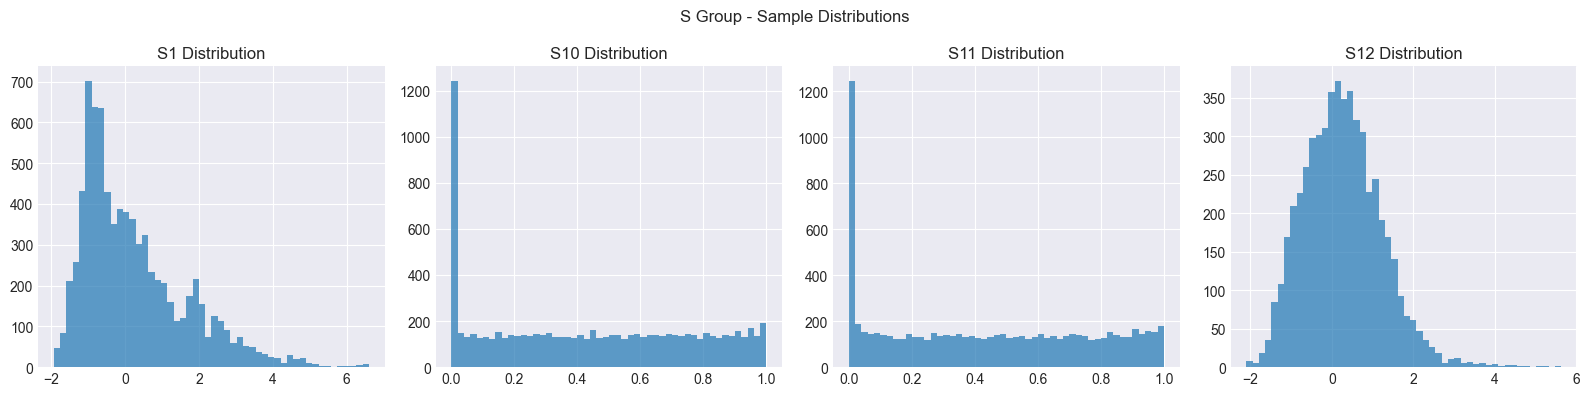

In [14]:
# Analyze each feature group
for group, features in loader.feature_groups.items():
    if not features or group == 'D':
        continue
    
    print(f"\n{'='*60}\n{group} Features ({len(features)})\n{'='*60}")
    
    # Descriptive statistics : count, mean, std, min, 25%, 50%, 75%, max
    desc = train_df[features].describe()
    print(desc)
    
    # Plot sample distributions
    sample_features = features[:min(4, len(features))]
    fig, axes = plt.subplots(1, len(sample_features), figsize=(16, 4))
    if len(sample_features) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(sample_features):
        train_df[feat].hist(bins=50, ax=axes[idx], alpha=0.7) # 하나의 칼럼 데이터의 분포를 50개 구간으로 나눈 그래프
        axes[idx].set_title(f'{feat} Distribution')
    
    plt.suptitle(f'{group} Group - Sample Distributions')
    plt.tight_layout()
    plt.show()

## 5. Target Variable Analysis

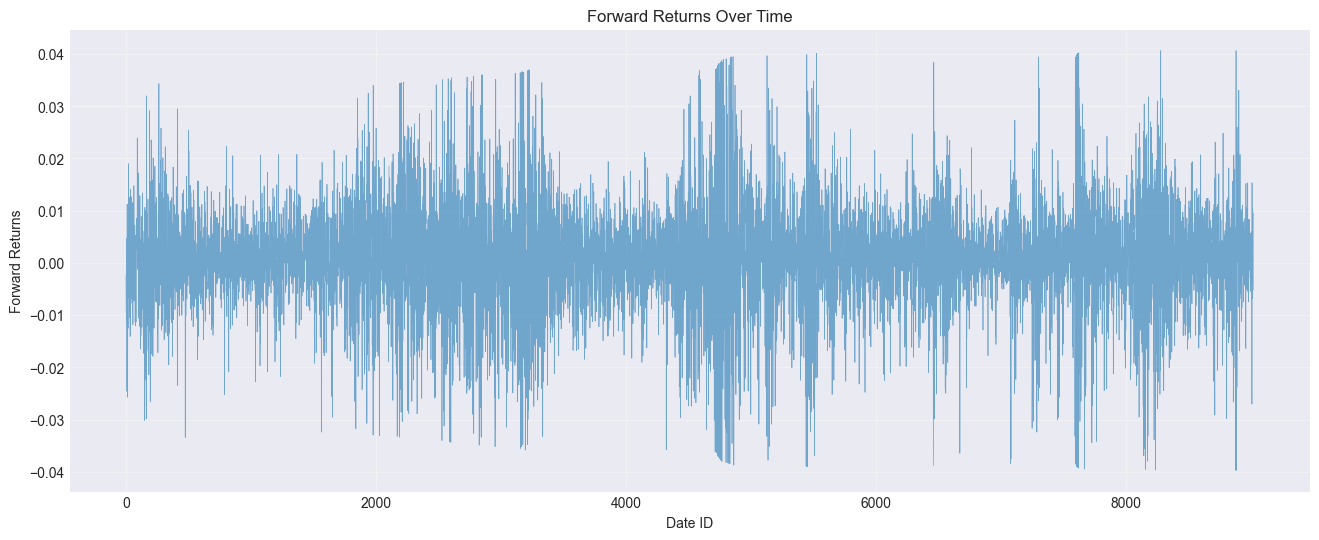

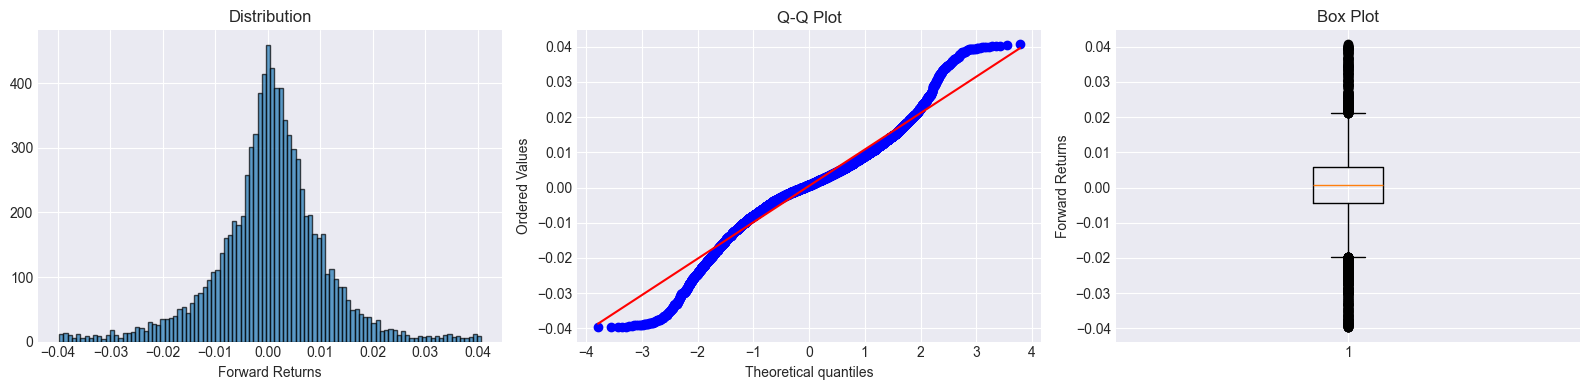

Mean: 0.000471
Std: 0.010541
Skewness: -0.1782
Kurtosis: 2.1979


In [5]:
target = 'forward_returns'  # S&P500의 다음날 수익률

# Time series plot
plt.figure(figsize=(16, 6))
plt.plot(train_df['date_id'], train_df[target], alpha=0.6, linewidth=0.5)
plt.title('Forward Returns Over Time')
plt.xlabel('Date ID')
plt.ylabel('Forward Returns')
plt.grid(True, alpha=0.3)
plt.show()

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram
axes[0].hist(train_df[target].dropna(), bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution')
axes[0].set_xlabel('Forward Returns')

# Q-Q plot
stats.probplot(train_df[target].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

# Box plot
axes[2].boxplot(train_df[target].dropna())
axes[2].set_title('Box Plot')
axes[2].set_ylabel('Forward Returns')

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean: {train_df[target].mean():.6f}")
print(f"Std: {train_df[target].std():.6f}")
print(f"Skewness: {stats.skew(train_df[target].dropna()):.4f}")
print(f"Kurtosis: {stats.kurtosis(train_df[target].dropna()):.4f}")

## 6. Autocorrelation Analysis

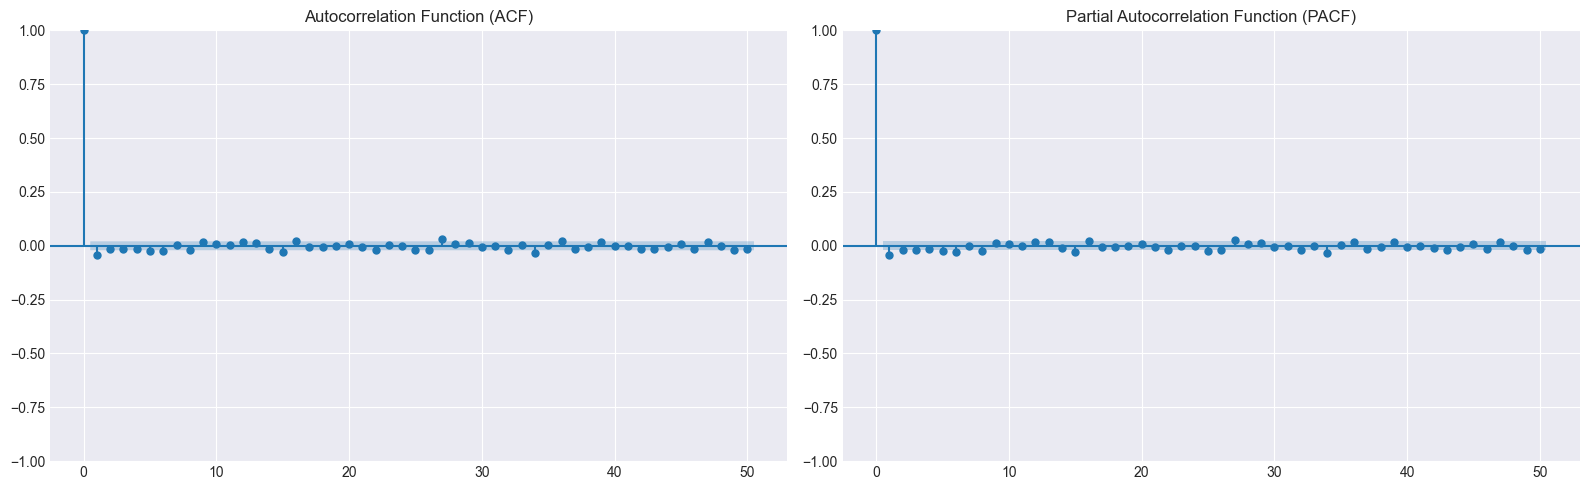

Significant ACF lags (|r| > 0.05):


In [6]:
# 시계열 데이터(회귀)의 성질을 분석하는데 활용되는 상관도표(Correlogram) : ACF and PACF plots
# x가 0일때는 y는 무조건 1, 그 외 x값인경우, y는 0이랑 가까울수록 좋다. 
# -> 0이랑 가까울 수록 독립적. (파란영역 안에 들어와야 좋음.)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF (Autocorrelation Function, 자기 상관 함수) : 전체 상관 측정
plot_acf(train_df[target].dropna(), lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PSCF (Partial Autocorrelation Function, 편자기상관함수) : 개별 시차별 자기 상관 측정
plot_pacf(train_df[target].dropna(), lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Print significant lags
acf_vals = acf(train_df[target].dropna(), nlags=20)
print("Significant ACF lags (|r| > 0.05):")
for i, val in enumerate(acf_vals[1:], 1):
    if abs(val) > 0.05:
        print(f"  Lag {i}: {val:.4f}")

## 7. Correlation Analysis

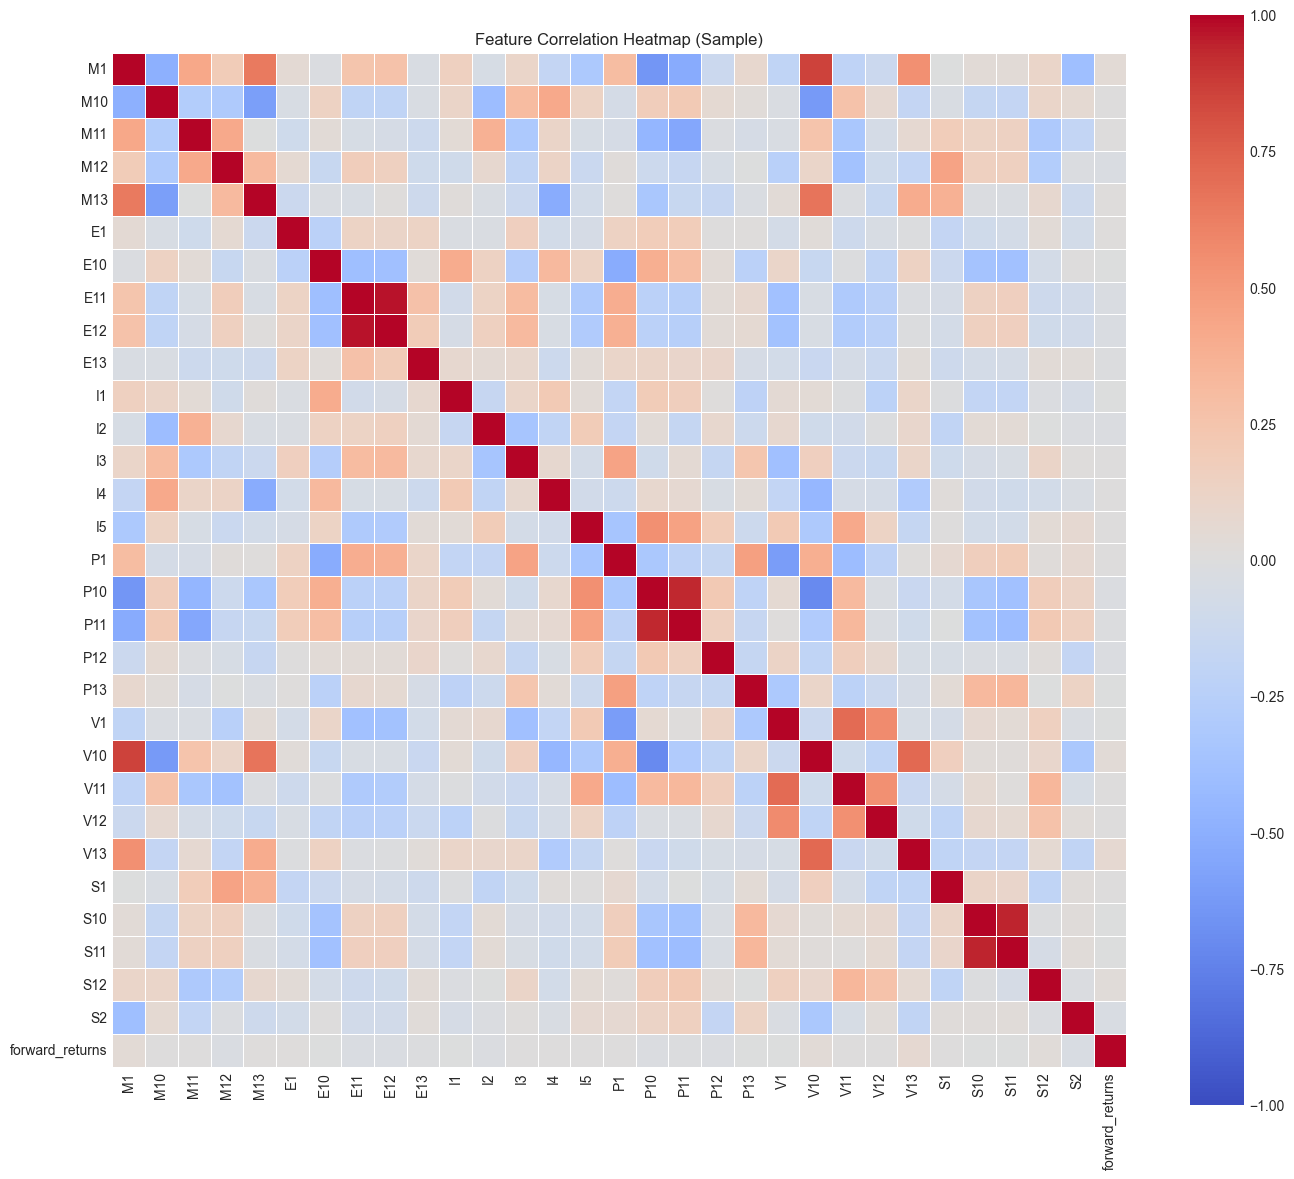


Top 10 Positive Correlations with Target:
V13   0.0631
M1    0.0448
V10   0.0317
S12   0.0248
M13   0.0104
E1    0.0087
M10   0.0075
M11   0.0070
I5    0.0068
I3    0.0049
Name: forward_returns, dtype: float64

Top 10 Negative Correlations with Target:
I1    -0.0057
E13   -0.0086
P11   -0.0093
P10   -0.0167
P12   -0.0219
I2    -0.0227
M12   -0.0239
E12   -0.0296
E11   -0.0309
S2    -0.0376
Name: forward_returns, dtype: float64


In [7]:
# Sample features for correlation
sample_features = []
for group, features in loader.feature_groups.items():
    if group != 'D' and features:
        sample_features.extend(features[:min(5, len(features))])

sample_features.append(target)

# Correlation matrix
corr_matrix = train_df[sample_features].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap (Sample)')
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = corr_matrix[target].drop(target).sort_values(ascending=False)
print("\nTop 10 Positive Correlations with Target:")
print(target_corr.head(10))
print("\nTop 10 Negative Correlations with Target:")
print(target_corr.tail(10))

## 8. Market Regime Analysis

현재 노트북에서는 forward_returns 열과 다른 피처 그룹(예: V로 시작하는 열들)에 대해 롤링 변동성을 계산하고 있습니다. 이때 윈도우 크기는 설정 파일(config['model_risk']['risk_window'])에서 정의된 값을 사용합니다. 롤링 변동성은 데이터의 고변동(high volatility) 또는 저변동(low volatility) 구간을 식별하는 데 유용하며, 시장 상태 분석이나 리스크 평가에 자주 활용됩니다.



Volatility Quartiles (window=60):
0.2500   0.0068
0.5000   0.0085
0.7500   0.0120
Name: rolling_vol, dtype: float64


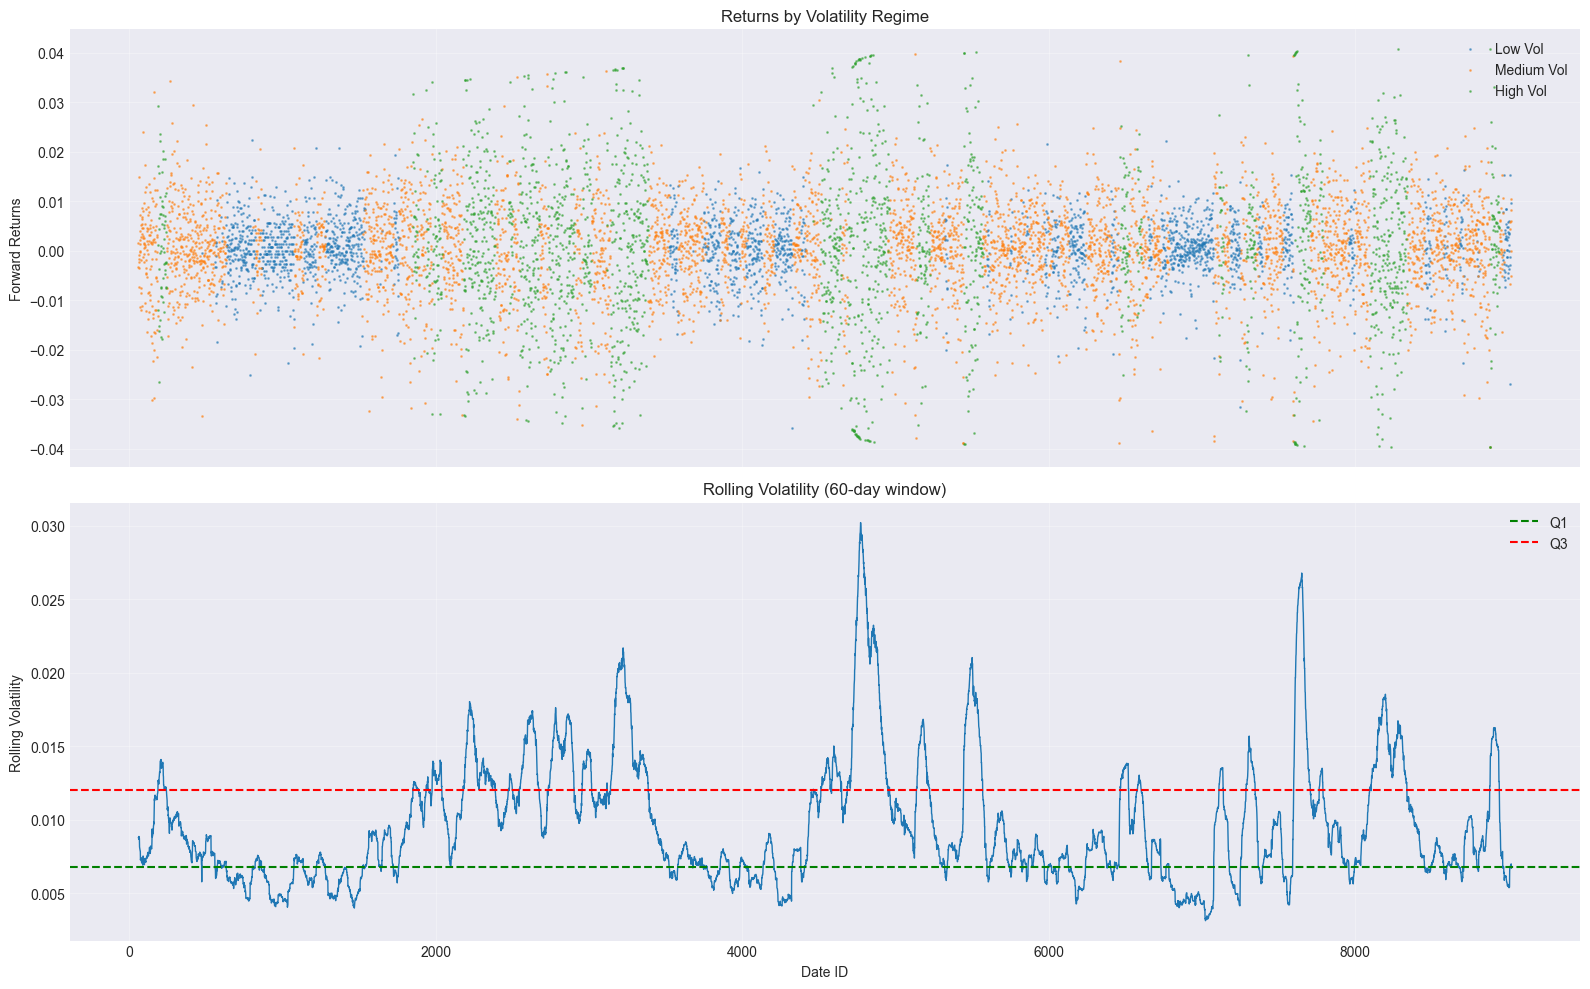


Performance by Regime:
            count    mean    std     min    max
regime                                         
High Vol     2241  0.0008 0.0155 -0.0398 0.0407
Low Vol      2241  0.0004 0.0060 -0.0358 0.0223
Medium Vol   4480  0.0004 0.0092 -0.0396 0.0397
Unknown        59 -0.0007 0.0089 -0.0257 0.0190


In [ ]:

# Calculate rolling volatility (using config window)
window = 60
train_df['rolling_vol'] = train_df[target].rolling(window).std()

# 변동성 기준점 설정 (Quartiles)
vol_quartiles = train_df['rolling_vol'].quantile([0.25, 0.5, 0.75])
print(f"Volatility Quartiles (window={window}):\n{vol_quartiles}")

# Classify regimes
def classify_regime(vol):
    if pd.isna(vol):
        return 'Unknown'
    elif vol < vol_quartiles[0.25]:
        return 'Low Vol'
    elif vol < vol_quartiles[0.75]:
        return 'Medium Vol'
    else:
        return 'High Vol'

train_df['regime'] = train_df['rolling_vol'].apply(classify_regime)

# Plot regimes
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Returns with regime coloring || Low Vol - 파란색, Medium Vol - 주황색, High Vol - 초록색
for regime in ['Low Vol', 'Medium Vol', 'High Vol']:
    mask = train_df['regime'] == regime
    axes[0].scatter(train_df.loc[mask, 'date_id'], 
                   train_df.loc[mask, target],
                   label=regime, alpha=0.5, s=1)
axes[0].set_ylabel('Forward Returns')
axes[0].legend()
axes[0].set_title('Returns by Volatility Regime')
axes[0].grid(True, alpha=0.3)

# Rolling volatility
axes[1].plot(train_df['date_id'], train_df['rolling_vol'], linewidth=1)
axes[1].axhline(vol_quartiles[0.25], color='g', linestyle='--', label='Q1')
axes[1].axhline(vol_quartiles[0.75], color='r', linestyle='--', label='Q3')
axes[1].set_xlabel('Date ID')
axes[1].set_ylabel('Rolling Volatility')
axes[1].legend()
axes[1].set_title(f'Rolling Volatility ({window}-day window)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance by regime
print("\nPerformance by Regime:")
regime_stats = train_df.groupby('regime')[target].agg(['count', 'mean', 'std', 'min', 'max'])
print(regime_stats)

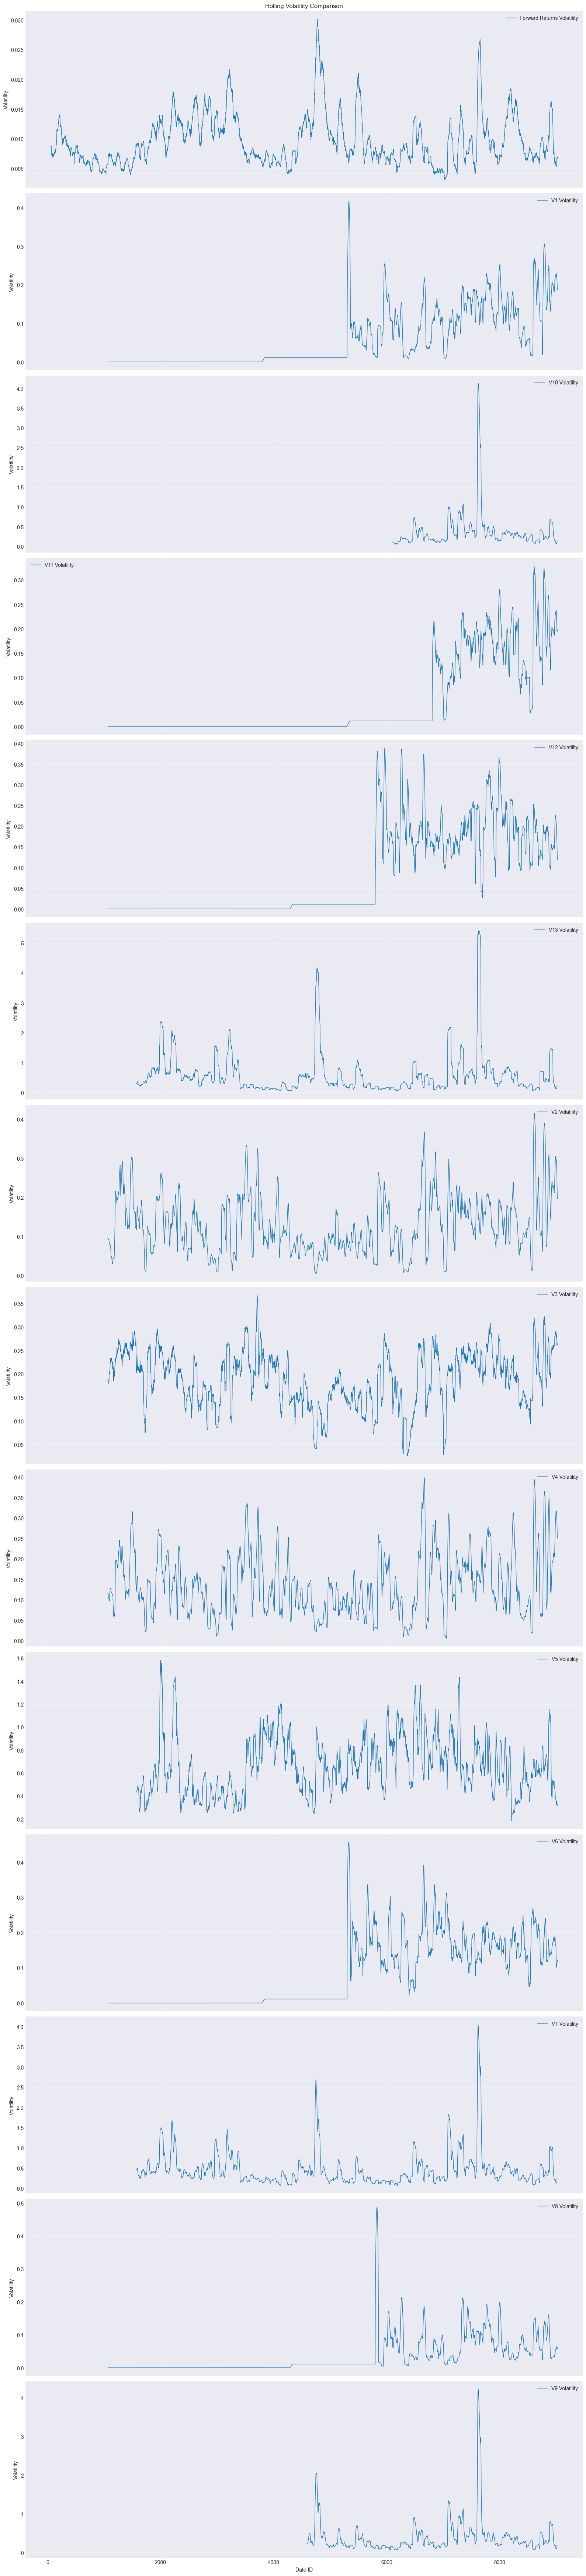

In [9]:
# Compare rolling volatility of V columns with forward_returns
v_columns = [col for col in train_df.columns if col.startswith('V')]
rolling_vol_v = train_df[v_columns].rolling(window).std()

# Plot comparison
fig, axes = plt.subplots(len(v_columns) + 1, 1, figsize=(16, 5 * (len(v_columns) + 1)), sharex=True)

# Rolling volatility of forward_returns
axes[0].plot(train_df['date_id'], train_df['rolling_vol'], linewidth=1, label='Forward Returns Volatility')
axes[0].set_title('Rolling Volatility Comparison')
axes[0].set_ylabel('Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling volatility of V columns
for idx, col in enumerate(v_columns):
    axes[idx + 1].plot(train_df['date_id'], rolling_vol_v[col], linewidth=1, label=f'{col} Volatility')
    axes[idx + 1].set_ylabel('Volatility')
    axes[idx + 1].legend()
    axes[idx + 1].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date ID')
plt.tight_layout()
plt.show()

## 9. Stationarity Tests

이 셀은 Augmented Dickey-Fuller (ADF) 테스트를 사용하여 특정 피처(feature)들이 
**정상성(stationarity)**을 가지는지 평가합니다. 정상성은 시계열 데이터 분석에서 중요한 개념으로, 
데이터의 평균과 분산이 시간에 따라 일정한지를 나타냅니다. 아래는 코드의 주요 부분과 그 의미를 단계별로 설명합니다:

In [10]:
# Test stationarity for target and sample features
test_features = [target] + [f for g, feats in loader.feature_groups.items() 
                            for f in feats[:2] if g != 'D' and feats][:10] # 전체 다 하려면 [:2], [:10] 제거

stationarity_results = []

for feat in test_features:
    series = train_df[feat].dropna()
    
    if len(series) < 50:
        continue
    
    # ADF test
    '''
    * 각 피처에 대해 다음을 수행합니다:
    1. 결측값 제거: dropna()를 사용하여 결측값을 제거합니다.
    2. 샘플 크기 확인: 데이터가 50개 미만인 경우 테스트를 건너뜁니다.
    3. ADF 테스트 실행: adfuller 함수를 사용하여 ADF 테스트를 수행합니다.
    4. adfuller는 정상성을 평가하는 통계량과 p-value를 반환합니다.
    5. 결과 저장: 피처 이름, ADF 통계량, p-value, 정상성 여부를 저장합니다.
    '''
    adf_result = adfuller(series, autolag='AIC')
    
    stationarity_results.append({
        'Feature': feat,
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'Stationary (p<0.05)': adf_result[1] < 0.05
    })

stationarity_df = pd.DataFrame(stationarity_results)
print("Stationarity Test Results (ADF):")
print(stationarity_df.sort_values('ADF p-value'))

# Count stationary vs non-stationary
n_stationary = stationarity_df['Stationary (p<0.05)'].sum()
n_total = len(stationarity_df)
print(f"\nStationary: {n_stationary}/{n_total} ({n_stationary/n_total*100:.1f}%)") 

Stationarity Test Results (ADF):
            Feature  ADF Statistic  ADF p-value  Stationary (p<0.05)
0   forward_returns       -17.5487       0.0000                 True
1                M1        -5.1324       0.0000                 True
3                E1        -5.1188       0.0000                 True
5                I1        -4.8477       0.0000                 True
7                P1        -4.4966       0.0002                 True
2               M10        -4.2340       0.0006                 True
10              V10        -3.9754       0.0015                 True
6                I2        -3.4515       0.0093                 True
9                V1        -2.9288       0.0421                 True
8               P10        -2.6359       0.0858                False
4               E10        -2.5167       0.1115                False

Stationary: 9/11 (81.8%)


## 10. Train/Test Distribution Shift

이 셀은 Kolmogorov-Smirnov (KS) 테스트를 사용하여 훈련 데이터(train_df)와 테스트 데이터(test_df) 간의 특징 분포 차이를 분석합니다. KS 테스트는 두 데이터 분포가 동일한지 여부를 평가하는 비모수적 통계 테스트입니다. 아래는 코드의 주요 부분과 그 의미를 단계별로 설명합니다.

In [11]:
from scipy.stats import ks_2samp

# Compare distributions for common features
common_features = [c for c in train_df.columns if c in test_df.columns 
                   and c not in ['date_id', 'is_scored']]

# Sample features to test
test_sample = [f for f in common_features if not f.startswith('lagged')][:15]

shift_results = []

for feat in test_sample:
    train_vals = train_df[feat].dropna()
    test_vals = test_df[feat].dropna()
    
    if len(train_vals) < 10 or len(test_vals) < 5:
        continue
    
    # KS test
    ks_stat, ks_pval = ks_2samp(train_vals, test_vals)
    
    shift_results.append({
        'Feature': feat,
        'KS Statistic': ks_stat,
        'KS p-value': ks_pval,
        'Significant Shift (p<0.05)': ks_pval < 0.05
    })

shift_df = pd.DataFrame(shift_results)
print("Distribution Shift Analysis (KS Test):")
print(shift_df.sort_values('KS Statistic', ascending=False))

# Count shifts
n_shifts = shift_df['Significant Shift (p<0.05)'].sum()
print(f"\nFeatures with significant shift: {n_shifts}/{len(shift_df)}")

Distribution Shift Analysis (KS Test):
   Feature  KS Statistic  KS p-value  Significant Shift (p<0.05)
10     E10        0.7256      0.0000                        True
3       D4        0.5740      0.0012                        True
9       E1        0.5331      0.0035                        True
11     E11        0.4926      0.0093                        True
12     E12        0.3825      0.0800                       False
13     E13        0.3577      0.1194                       False
5       D6        0.2381      0.5460                       False
14     E14        0.2164      0.6627                       False
4       D5        0.2096      0.6992                       False
8       D9        0.1570      0.9353                       False
7       D8        0.0573      1.0000                       False
6       D7        0.0543      1.0000                       False
2       D3        0.0522      1.0000                       False
0       D1        0.0316      1.0000               

## 11. Benchmark Calculation

2025-11-21 15:34:14,289 - shared_logger - INFO - Benchmark Score: 0.0447
2025-11-21 15:34:14,290 - shared_logger - INFO - Annual Sharpe: 0.7100
2025-11-21 15:34:14,290 - shared_logger - INFO - Volatility Penalty: 1.0000
2025-11-21 15:34:14,291 - shared_logger - INFO - Max Drawdown: -49.24%


BENCHMARK METRICS (Allocation = 1.0)

Score: 0.0447
Sharpe Ratio: 0.0447
Annual Sharpe: 0.7100
Volatility Penalty: 1.0000

Annual Return: 11.88%
Annual Volatility: 16.73%
Max Drawdown: -49.24%
Win Rate: 53.94%


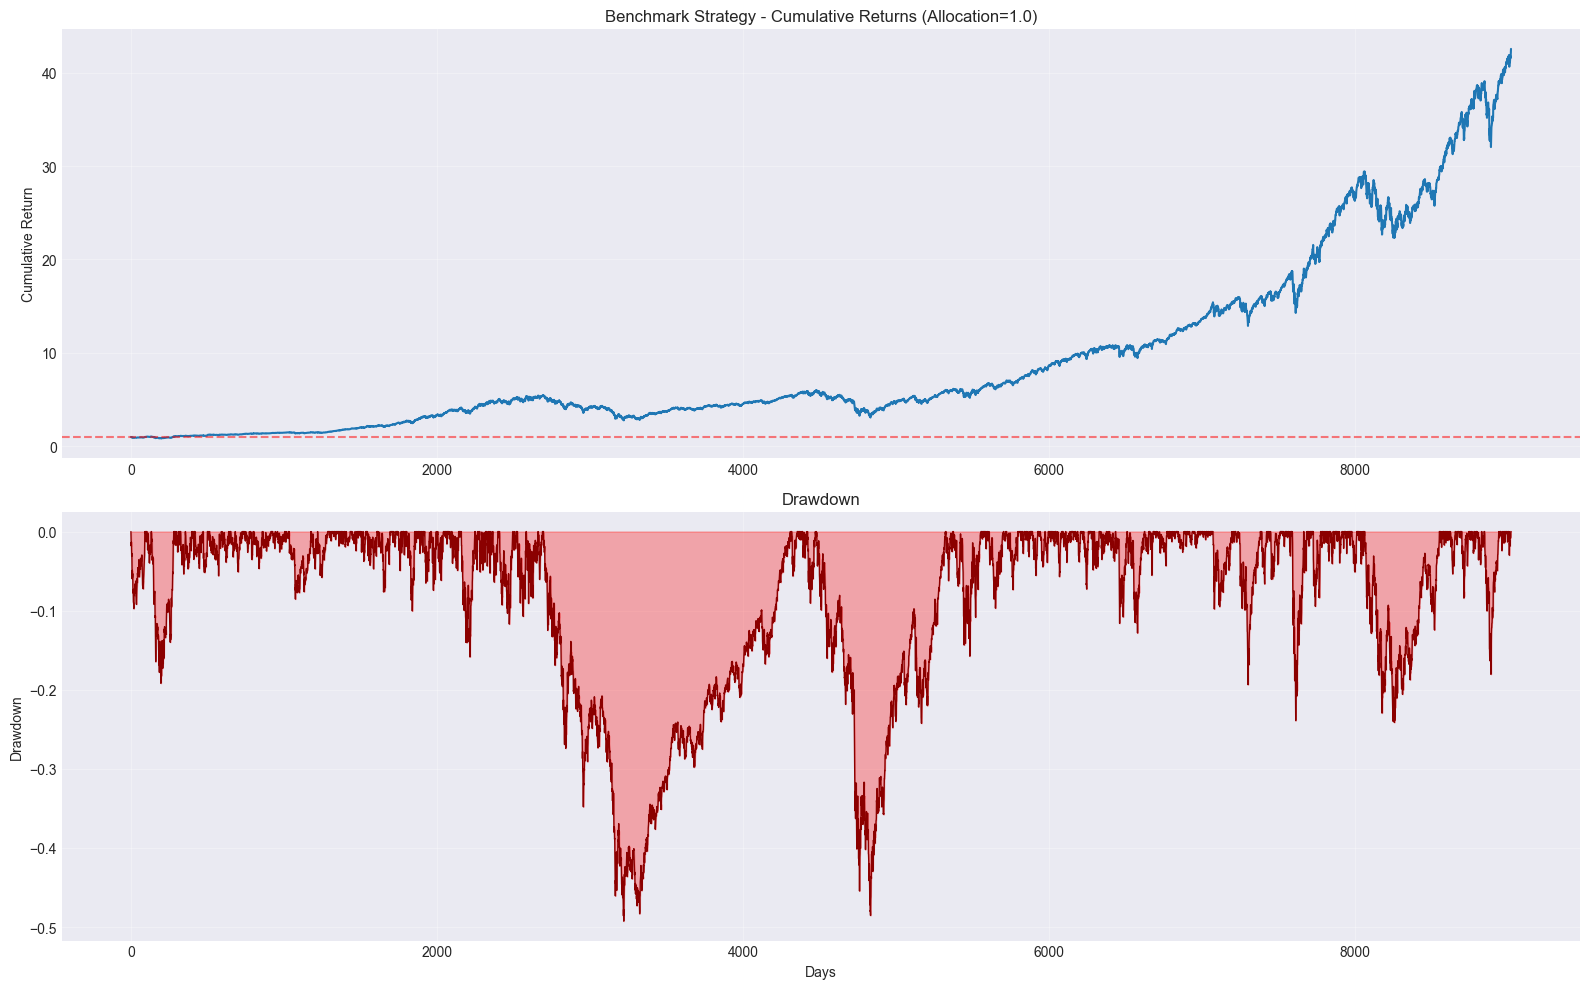

In [12]:
# Calculate benchmark with allocation=1.0
score, returns, metrics = calculate_benchmark_score(train_df, allocation=1.0)

print("=" * 60)
print("BENCHMARK METRICS (Allocation = 1.0)")
print("=" * 60)
print(f"\nScore: {score:.4f}")
print(f"Sharpe Ratio: {metrics['sharpe']:.4f}")
print(f"Annual Sharpe: {metrics['annual_sharpe']:.4f}")
print(f"Volatility Penalty: {metrics['vol_penalty']:.4f}")
print(f"\nAnnual Return: {metrics['annual_return']:.2%}")
print(f"Annual Volatility: {metrics['annual_vol']:.2%}")
print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
print(f"Win Rate: {metrics['win_rate']:.2%}")

# Cumulative returns plot
cumulative_returns = (1 + returns).cumprod()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Cumulative returns
axes[0].plot(cumulative_returns.values, linewidth=1.5)
axes[0].set_title('Benchmark Strategy - Cumulative Returns (Allocation=1.0)')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)

# Drawdown
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max

axes[1].fill_between(range(len(drawdown)), drawdown.values, 0, alpha=0.3, color='red')
axes[1].plot(drawdown.values, linewidth=1, color='darkred')
axes[1].set_title('Drawdown')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Drawdown')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Summary and Insights

In [13]:
print("="*60)
print("EDA SUMMARY")
print("="*60)

print(f"\n📦 Data Shape:")
print(f"  Train: {train_df.shape}")
print(f"  Test: {test_df.shape}")

print(f"\n🏷️ Feature Groups:")
for group, features in loader.feature_groups.items():
    print(f"  {group}: {len(features)} features")

print(f"\n📊 Target Statistics:")
print(f"  Mean: {train_df[target].mean():.6f}")
print(f"  Std: {train_df[target].std():.6f}")
print(f"  Sharpe: {train_df[target].mean()/train_df[target].std():.4f}")

print(f"\n🎯 Benchmark Performance:")
print(f"  Score: {score:.4f}")
print(f"  Annual Sharpe: {metrics['annual_sharpe']:.4f}")
print(f"  Max Drawdown: {metrics['max_drawdown']:.2%}")

print(f"\n⚠️ Key Findings:")
print(f"  - Stationary features: {n_stationary}/{n_total}")
print(f"  - Distribution shifts: {n_shifts}/{len(shift_df)}")
print(f"  - Missing data: See quality check above")

print("\n✅ EDA Complete!")

EDA SUMMARY

📦 Data Shape:
  Train: (9021, 100)
  Test: (10, 99)

🏷️ Feature Groups:
  M: 18 features
  E: 20 features
  I: 9 features
  P: 13 features
  V: 13 features
  S: 12 features
  D: 9 features

📊 Target Statistics:
  Mean: 0.000471
  Std: 0.010541
  Sharpe: 0.0447

🎯 Benchmark Performance:
  Score: 0.0447
  Annual Sharpe: 0.7100
  Max Drawdown: -49.24%

⚠️ Key Findings:
  - Stationary features: 9/11
  - Distribution shifts: 4/15
  - Missing data: See quality check above

✅ EDA Complete!
